Source: https://github.com/Lucasc-99/Actor-Critic

In [13]:
from typing import List

import torch
from torch import nn
from torch import optim
from torch.distributions import Categorical
import gym

from octopus.policy.reward import calculate_discounted_return_each_timestep, calculate_advantages

In [14]:
class ActorNet(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_observations, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.layers(state)

In [15]:
class CriticNet(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_observations, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, state):
        return self.layers(state)

In [4]:
# class A2C(nn.Module):
#     def __init__(self, n_observations, n_actions, hidden_size):
#         super().__init__()
#         self.actor = nn.Sequential(
#             nn.Linear(n_observations, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, n_actions),
#             nn.Softmax(dim=-1)
#         )
        
#         self.critic = nn.Sequential(
#             nn.Linear(n_observations, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, 1)
#         )
    
#     def forward(self, state):
#         pred_action = self.actor(state)
#         pred_value = self.critic(state)
        
#         return pred_action, pred_value

In [ ]:
model

In [ ]:
config = dict (
    learning_rate = 0.01,
    momentum = 0.2,
    architecture = "CNN",
    dataset_id = "peds-0192",
    infra = "AWS",
)

In [5]:
gym_id = "CartPole-v1"
exp_name = "A2C"
seed = 42

In [6]:
import wandb
import time

run_name = f"{gym_id}__{exp_name}__{seed}__x_{int(time.time())}"

wandb.init(
    project="simple_a2c",
    # entity=args.wandb_entity,
    sync_tensorboard=True,
    # config=vars(args),
    name=run_name,
    monitor_gym=True,
    save_code=True,
)

wandb: Currently logged in as: xariusdrake. Use `wandb login --relogin` to force relogin


In [16]:
run_name

'CartPole-v1__A2C__42__x_1671859865'

In [17]:
env = gym.make(gym_id)

In [18]:
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

actor = ActorNet(n_observations, n_actions, hidden_size=128)
critic = CriticNet(n_observations, n_actions, hidden_size=128)

LEARNING_RATE = 0.001

actor_optim = optim.Adam(actor.parameters(), lr=LEARNING_RATE)
critic_optim = optim.Adam(critic.parameters(), lr=LEARNING_RATE)
    
# critic_loss_func = nn.MSELoss()
critic_loss_func = nn.SmoothL1Loss()

In [21]:
actor

ActorNet(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
    (3): Softmax(dim=-1)
  )
)

In [10]:
def compute_actor_loss(log_probs: List[torch.Tensor], advantages: List[torch.Tensor]):
    """Calculate the advantage loss for actor

    Args:
        log_probs (_type_): a list of 
        advantages (_type_): _description_

    Returns:
        _type_: _description_
    """
    assert len(log_probs) == len(advantages)
    
    total_loss = 0
    for log_prob, advantage in zip(log_probs, advantages):
        total_loss = log_prob * advantage
    
    # return -(torch.sum(log_probs * advantages))
    return -total_loss

In [12]:
N_EPISODES = 10000
DISCOUNT_FACTOR = 0.99

episode_rewards = []
episode_actor_losses = []
episode_critic_losses = []

for episode in range(N_EPISODES):
    
    pred_log_probs = []
    pred_q_values = []
    rewards = []
    total_reward = 0

    observation, _ = env.reset()
    observation = torch.from_numpy(observation)
    in_progress = True
    
    while in_progress:
        pred_action = actor(observation)
        pred_value = critic(observation)

        action_idx = Categorical(pred_action).sample().item()
                        
        new_observation, reward, done, truncated, info = env.step(action_idx)
        reward = torch.tensor(reward)
        
        pred_log_probs.append(pred_action[action_idx].log())
        pred_q_values.append(pred_value)
        rewards.append(reward)
        total_reward += reward
        
        if done: break
        
        observation = torch.from_numpy(new_observation)
        
        
    # TODO: this one make it loss grad
    # pred_q_values = torch.tensor(pred_q_values)
    
    discounted_returns = calculate_discounted_return_each_timestep(rewards, DISCOUNT_FACTOR)
    advantages = calculate_advantages(discounted_returns, torch.tensor(pred_q_values))
    loss_actor = compute_actor_loss(pred_log_probs, advantages)
    
    _pred_q_values = torch.tensor(pred_q_values)
    _pred_q_values.requires_grad = True
    loss_critic = critic_loss_func(discounted_returns, _pred_q_values)
    
    episode_actor_losses.append(loss_actor.detach().numpy())
    episode_critic_losses.append(loss_critic.detach().numpy())
    episode_rewards.append(total_reward)
    
    wandb.log({
        "actor_losses": loss_actor.detach().numpy(),
        "critic_losses": loss_critic.detach().numpy(),
        "rewards": total_reward
    })

    
    actor_optim.zero_grad()
    critic_optim.zero_grad()
    
    loss_actor.backward()
    loss_critic.backward()
    
    actor_optim.step()
    critic_optim.step()
    
    print(f"episode={episode} loss_actor={loss_actor}, loss_critic={loss_critic}")

KeyboardInterrupt: 

In [74]:
import numpy as np

np.array(episode_rewards).var()

15.529225

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


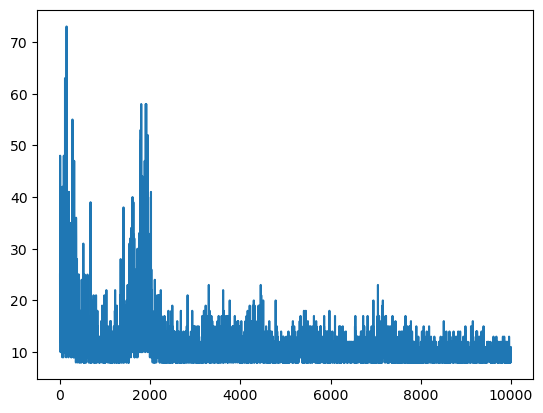

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [75]:
import matplotlib.pyplot as plt
plt.plot(episode_rewards)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


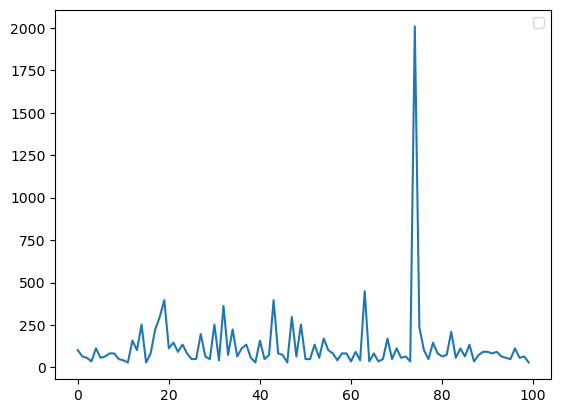

In [69]:
# import matplotlib.pyplot as plt
# plt.plot(episode_critic_losses)

# plt.legend()

# # show the plot
# plt.show()

In [71]:
# import matplotlib.pyplot as plt
# plt.plot(episode_actor_losses)

# plt.legend()

# # show the plot
# plt.show()